# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: avito_data.csv          
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [2]:
!pip install pandas scikit-learn matplotlib

     |████████████████████████████████| 10.0 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 5.3 MB/s eta 0:00:01


## Сверточные нейронные сети

Несколько полносвязных слоев (с нелинейностями посередине) - это уже полноценная нейронная сеть. Однако это скорее какая-то базовая вещь. Действительно нужен полносвязный слой только в конце сети, а в качестве основных используются сверточные или рекуррентные слои. Главное их отличие (=преимущество) - учитывание структукры данных. В этом семинаре мы попробуем использовать сверточные сети. Лучше всего они работают в картинках, но для текстов их тоже можно применять (они быстрее рекуррентных и могут лучше работать на длинных последовательностях).

Про то как работают сверточные слои посмотрите в этом видео - https://www.youtube.com/watch?v=bNb2fEVKeEo

Основная идея - использовать много небольших (сильно меньше размера текста или картинки) матриц, которые применяются к кусочкам векторизованного текста/картинки. Между кусочком и матрицей считается близость, и эта близость передается дальше по сети. Т.е. кусочек как-бы **сворачивается** в одно число. 

Эти небольшие матрицы обучаются на данных и, например, для картинок в них собираются различные паттерны, важные для задачи. Например, для определения рукописных цифр, такие матрицы могут представлять горизонтальные черточки, волнистые линии, кружки и т.д. Есть даже целое направление исследований, которое занимается визуализацией и интерпретацией обученных сверток.

Из-за того, что матрицы применяются к кусочкам, а не отедльным элементам, гораздо лучше учитывается структура. 

## Классификация с помощью CNN

Давайте посмотрим, как в тензорфлоу использовать сверточные сети и как их соединять с Embedding и Dense слоями.

Данные из того же соревнования от Quora - https://www.kaggle.com/c/quora-insincere-questions-classification/overview  
В этом соревновании нужно было предсказывать токсичность вопроса.

In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

Предобработка нам тут особо не важна.

In [3]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

In [4]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
quora = pd.read_csv('quora.csv')

In [6]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


Предобработка точно такая же

In [7]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [8]:
len(vocab)

273056

In [9]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

In [10]:
len(filtered_vocab)

48010

In [11]:
# индексируем слова
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [15]:
MEAN_LEN = np.median([len(x) for x in X])

In [16]:
MAX_LEN, MEAN_LEN

(134, 11.0)

In [17]:
# MAX_LEN = MEAN_LEN + 5

In [18]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [19]:
X.shape

(1306122, 134)

In [20]:
y = quora.target.values

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

Для сравнения сначала обучим сеть только с помощью Dense слоев.

In [47]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
mean = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              # фмеры тут нет, но есть точность и полнота по отдельности
              # name тут нужен для удобства,
              # иначе метрика будет называться типа "Precision_i"
              # и придется менять i в дальнейших визуализациях 
              metrics=[f1])



In [48]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 48s 78ms/step - loss: 0.1319 - f1: 0.4800 - val_loss: 0.1122 - val_f1: 0.5766
Epoch 2/5
621/621 [==============================] - 48s 77ms/step - loss: 0.1015 - f1: 0.6327 - val_loss: 0.1130 - val_f1: 0.5986
Epoch 3/5
621/621 [==============================] - 48s 77ms/step - loss: 0.0861 - f1: 0.7018 - val_loss: 0.1253 - val_f1: 0.5821
Epoch 4/5
621/621 [==============================] - 48s 77ms/step - loss: 0.0665 - f1: 0.7837 - val_loss: 0.1431 - val_f1: 0.5656
Epoch 5/5
621/621 [==============================] - 48s 77ms/step - loss: 0.0510 - f1: 0.8411 - val_loss: 0.1692 - val_f1: 0.5685


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


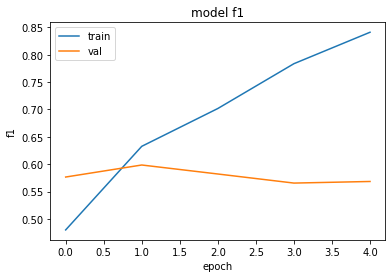

In [49]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

А теперь попробуем со сверточным слоем. В керасе они называются Conv1D (2D тоже есть, они используются для картинок). Их нужно ставить сразу после Embedding слоя.

In [67]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs, )

# все остальное точно такое же
# возвращает сверточный слой тоже последовательность векторов слегка измененной или такой же длины
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=32)(embeddings)

# выход со сверточного слоя также можно просто конкатенировать
concat = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [68]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 134)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 134, 10)           480120    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 125, 32)           3232      
_________________________________________________________________
flatten_15 (Flatten)         (None, 4000)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                256064    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 739,481
Trainable params: 739,481
Non-trainable params: 0
____________________________________________________

In [69]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

Epoch 1/5
1241/1241 [==============================] - 10s 8ms/step - loss: 0.1289 - f1: 0.5019 - val_loss: 0.1138 - val_f1: 0.5953
Epoch 2/5
1241/1241 [==============================] - 10s 8ms/step - loss: 0.1043 - f1: 0.6202 - val_loss: 0.1141 - val_f1: 0.6139
Epoch 3/5
1241/1241 [==============================] - 11s 9ms/step - loss: 0.0953 - f1: 0.6584 - val_loss: 0.1169 - val_f1: 0.6138
Epoch 4/5
1241/1241 [==============================] - 10s 8ms/step - loss: 0.0853 - f1: 0.6986 - val_loss: 0.1218 - val_f1: 0.6090
Epoch 5/5
1241/1241 [==============================] - 10s 8ms/step - loss: 0.0748 - f1: 0.7412 - val_loss: 0.1373 - val_f1: 0.5924


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


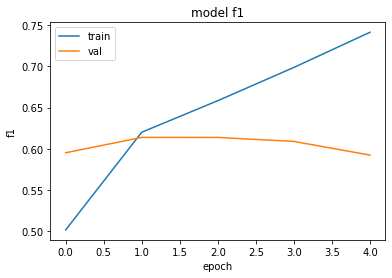

In [70]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Сверточные слои можно накладывать друг на друга.

Давайте еще разберем параметры:  
    **kernel_size** - это размер кусочков, к которым мы применяем сверточные матрицы (похоже на размер нграмма)   
    **filters** - количество матриц свертки  (это как бы размерность до которой будет сжат или развернут вектор)    
    **stride** - шаг по которому выбираются кусочки из последовательности (это как параметр шаг в функции range в питоне)  

In [60]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
concat = tf.keras.layers.Flatten()(conv2)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [61]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 134)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 134, 100)          7532000   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 130, 32)           16032     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 126, 32)           5152      
_________________________________________________________________
flatten_9 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                258112    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65  

In [62]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=5)

Epoch 1/5
621/621 [==============================] - 54s 87ms/step - loss: 0.1334 - f1: 0.4015 - val_loss: 0.1100 - val_f1: 0.5959
Epoch 2/5
621/621 [==============================] - 54s 86ms/step - loss: 0.0999 - f1: 0.6420 - val_loss: 0.1107 - val_f1: 0.5962
Epoch 3/5
621/621 [==============================] - 54s 86ms/step - loss: 0.0845 - f1: 0.7093 - val_loss: 0.1174 - val_f1: 0.6266
Epoch 4/5
621/621 [==============================] - 54s 86ms/step - loss: 0.0684 - f1: 0.7735 - val_loss: 0.1379 - val_f1: 0.6012
Epoch 5/5
621/621 [==============================] - 54s 86ms/step - loss: 0.0549 - f1: 0.8246 - val_loss: 0.1606 - val_f1: 0.5856


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


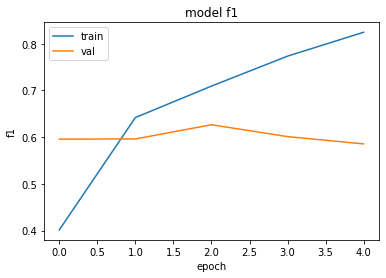

In [63]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Со сверточными слоями часто используется Pooling. Это тоже своего рода свертка, но без обучаемых параметров. В пулингах используется какое-то правило, по которому из чисел в каком-то окне выбирается 1 число (т.е. происходит свертка). В качестве правила используется максимум или среднее. Pooling слой ставят после сверточного. 

In [21]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
pool = tf.keras.layers.AveragePool1D()(conv2)

concat = tf.keras.layers.Flatten()(pool)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [22]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 51s 82ms/step - loss: 0.1336 - f1: 0.4274 - val_loss: 0.1116 - val_f1: 0.6017
Epoch 2/5
621/621 [==============================] - 51s 82ms/step - loss: 0.0997 - f1: 0.6419 - val_loss: 0.1126 - val_f1: 0.6018
Epoch 3/5
621/621 [==============================] - 51s 82ms/step - loss: 0.0831 - f1: 0.7141 - val_loss: 0.1247 - val_f1: 0.5872
Epoch 4/5
621/621 [==============================] - 51s 82ms/step - loss: 0.0654 - f1: 0.7860 - val_loss: 0.1412 - val_f1: 0.5911
Epoch 5/5
621/621 [==============================] - 51s 82ms/step - loss: 0.0475 - f1: 0.8507 - val_loss: 0.1743 - val_f1: 0.5873


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


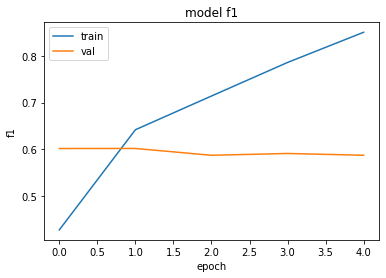

In [23]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

До этого мы разбирали сами слои и как-то не обращали внимание на результаты. А они получаются так себе. Видно, что есть переобучение.

Для борьбы с переобучением в нейронках есть регуляризация и Dropout. 

    Базовая регуляризация тут как в классических алгоритмах - l1 и l2. В большинстве слоев есть параметры smth_regularizer (можно строкой указать l1 или l2), где вместо smth какая-то специфичная часть слоя, которая обучается (kernel_regularizer в свертках  это регуляризация весов в матрицах).
    
    А Dropout - это отдельный слой, в котором часть подаваемых значений просто случайно зануляется. Это застявляет нейронку смотреть  на большее количество паттернов, а не переобучаться только на какой-то один.
 

In [27]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, 
                                               kernel_regularizer='l2')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = tf.keras.layers.Dropout(0.2)(conv2) # это значит что случайно заменяется половина всех значений

concat = tf.keras.layers.Flatten()(drop2)
dense = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l2')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [28]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 134)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 134, 100)          7532000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 130, 32)           16032     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 126, 32)           5152      
_________________________________________________________________
dropout_3 (Dropout)          (None, 126, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2016

In [29]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 51s 82ms/step - loss: 0.2667 - f1: 0.3277 - val_loss: 0.1518 - val_f1: 0.4447
Epoch 2/5
621/621 [==============================] - 51s 83ms/step - loss: 0.1431 - f1: 0.4980 - val_loss: 0.1447 - val_f1: 0.4563
Epoch 3/5
621/621 [==============================] - 51s 83ms/step - loss: 0.1341 - f1: 0.5466 - val_loss: 0.1402 - val_f1: 0.4973
Epoch 4/5
621/621 [==============================] - 51s 82ms/step - loss: 0.1288 - f1: 0.5797 - val_loss: 0.1354 - val_f1: 0.5578
Epoch 5/5
621/621 [==============================] - 51s 82ms/step - loss: 0.1246 - f1: 0.5986 - val_loss: 0.1342 - val_f1: 0.5368


Переобучаться стало сильно меньше.

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


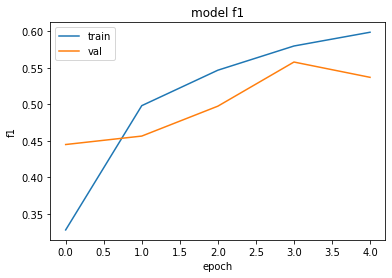

In [30]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Еще один параметр в сверточном слое - padding. Так как мы проходим каким-то окном по последовательности, на выходе последовательность сокращается. Но мы можем добавить нулей в начало и конец, чтобы на выходе было такое же число (padding='same').

Так мы можем наслаивать огромное количество слоев (она не уменьшается на каждом шаге).

А еще это позволяет, например, сделать вот такую сеть:

In [40]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

# мы делаем несколько параллельных сверточных слоев (даже пар слоев с пулингом) с разным окном
# но из-за того, что бы сделали паддинг, длинна получается одинаковая и мы можем сконкатенировать 
# векторы по второй размерности (так же как вы склеивали эбмединги от фастекста и ворд2века в предыдущей домашке)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

# а тут мы можем поставить еще свертку
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [41]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 134)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 134, 100)     7532000     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 134, 32)      6432        embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 134, 32)      9632        embedding_5[0][0]                
____________________________________________________________________________________________

In [43]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 74s 119ms/step - loss: 0.1395 - f1: 0.5652 - val_loss: 0.1131 - val_f1: 0.5932
Epoch 2/5
621/621 [==============================] - 73s 118ms/step - loss: 0.1038 - f1: 0.6289 - val_loss: 0.1124 - val_f1: 0.6063
Epoch 3/5
621/621 [==============================] - 73s 118ms/step - loss: 0.0965 - f1: 0.6603 - val_loss: 0.1151 - val_f1: 0.6117
Epoch 4/5
621/621 [==============================] - 73s 118ms/step - loss: 0.0900 - f1: 0.6902 - val_loss: 0.1218 - val_f1: 0.6074
Epoch 5/5
621/621 [==============================] - 73s 118ms/step - loss: 0.0831 - f1: 0.7202 - val_loss: 0.1308 - val_f1: 0.6107


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


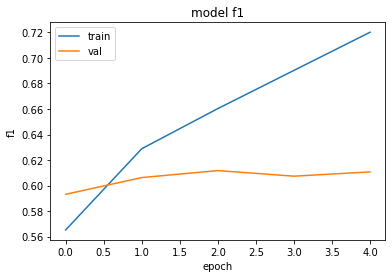

In [44]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

В Conv1D только один вариант паддинга - нулями. Но есть и другие способы (посмотрите лекцию по ссылке в начале). В функции tf.pad дает больше выбора паддинга. Его можно вставить в tf.keras.layers.Lambda, чтобы использовать в сети. 


In [138]:
# пример
tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                        [[0,0], [1,1], [0,0]], 
                                        mode='CONSTANT'))

# x тут это то, что будет на входе, например последовательность эмбедингов
#
# второй параметр - это значения паддинга для каждой из размерности слева и справа

# у нас будут последовательности вида (batch_size, max_len, embedding_size)

# с размером батча ничего не делаем, поэтому [0, 0]

# длину последовательности меняем, она связана с kernel_size как раз и меняется - [1, 1], 
# т.е. паддим одну колонку слева и одну справа (была 134, станет 136, например)

# размер эмбединга тоже не трогаем, т.к. фильтра применяется на всю глубину
#

# mode - это тип паддинга, CONSTANT - это паддинг нулями
# еще есть SYMMETRIC, REFLECT

# вот примеры, как это работает

# tf.pad(t, paddings, "CONSTANT")  # [[0, 0, 0, 0, 0, 0, 0],
#                                  #  [0, 0, 1, 2, 3, 0, 0],
#                                  #  [0, 0, 4, 5, 6, 0, 0],
#                                  #  [0, 0, 0, 0, 0, 0, 0]]

# tf.pad(t, paddings, "REFLECT")  # [[6, 5, 4, 5, 6, 5, 4],
#                                 #  [3, 2, 1, 2, 3, 2, 1],
#                                 #  [6, 5, 4, 5, 6, 5, 4],
#                                 #  [3, 2, 1, 2, 3, 2, 1]]

# tf.pad(t, paddings, "SYMMETRIC")  # [[2, 1, 1, 2, 3, 3, 2],
#                                   #  [2, 1, 1, 2, 3, 3, 2],
#                                   #  [5, 4, 4, 5, 6, 6, 5],
#                                   #  [5, 4, 4, 5, 6, 6, 5]]

### Попробуйте подбирать паддинги, чтобы понять, как это работает, на игрушечном тензоре

In [139]:
x = [[[1,2,3],[3, 4,5]], [[6,7,8], [9,10, 11]]]

In [144]:
np.array(x)

array([[[ 1,  2,  3],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [146]:
np.array(x).shape

(2, 2, 3)

In [140]:
tf.pad(x, [[0, 0], [1, 1], [0, 0]])

<tf.Tensor: shape=(2, 4, 3), dtype=int32, numpy=
array([[[ 0,  0,  0],
        [ 1,  2,  3],
        [ 3,  4,  5],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [ 0,  0,  0]]], dtype=int32)>

Это еще не все сложности.

Понадобится ещё разобраться в том, как расчитывается размер выхода из свертки в зависимости от размера фильтра.

В лекции была такая формула -   
output = (shape-kernel_size)/stride + 1


Из неё нам нужно вывести размер паддинга с каждой стороны нашей матрицы. Для этого нам нужно найти такой shape, при котором выход из свертки будет равняться нашему текущему shape.   
shape = (X-kernel_size)/stride + 1

Потом его нужно разделить на 2 и получить размер паддинга с каждой стороны. 

Получается что-то такое -   
X = ((((shape - 1) * stride) + kernel_size) - shape) / 2 (может еще упрощается, но я давно не считал руками)

Тут еще нужно учесть, что не при любом значении kernel_size будут получаться четные числа, а это значит нужно будет паддить не ровно. Это вы можете доделать самостоятельно. Я просто взял значения kernel_size (3,5), при которых все сходится.

Еще небольшая проблема в том, что мы не можем задать сетку, как это делали выше (через цикл). Я не знаю, почему так, но если развернуть цикл и написать все без переменных, то работает.

In [129]:
# Паддинг для kernel_size=3
ks = 3
((((MAX_LEN - 1) * 1) + ks) -  MAX_LEN) / 2

1.0

In [130]:
# Паддинг для kernel_size=5
ks = 5
((((MAX_LEN - 1) * 1) + ks) -  MAX_LEN) / 2

2.0

In [149]:

inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


# kernel_size = 3
pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)

pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(conv1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


#kernel_size = 5
pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(conv3)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)



concat = tf.keras.layers.concatenate([conv2, conv4])

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [150]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 134)]        0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 134, 100)     4801200     input_35[0][0]                   
__________________________________________________________________________________________________
lambda_92 (Lambda)              (None, 136, 100)     0           embedding_34[0][0]               
__________________________________________________________________________________________________
lambda_94 (Lambda)              (None, 138, 100)     0           embedding_34[0][0]               
___________________________________________________________________________________________

In [151]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 65s 105ms/step - loss: 0.1882 - f1: 0.5104 - val_loss: 0.1141 - val_f1: 0.5666
Epoch 2/5
621/621 [==============================] - 65s 105ms/step - loss: 0.1048 - f1: 0.6265 - val_loss: 0.1118 - val_f1: 0.6257
Epoch 3/5
621/621 [==============================] - 66s 105ms/step - loss: 0.0967 - f1: 0.6600 - val_loss: 0.1132 - val_f1: 0.6045
Epoch 4/5
621/621 [==============================] - 65s 105ms/step - loss: 0.0898 - f1: 0.6939 - val_loss: 0.1203 - val_f1: 0.6135
Epoch 5/5
621/621 [==============================] - 65s 105ms/step - loss: 0.0824 - f1: 0.7253 - val_loss: 0.1292 - val_f1: 0.6185


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


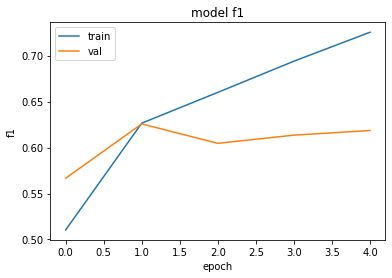

In [152]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Сохранение и загрузка модели

Когда какая-то модель получилась, её может потребоваться сохранить.

In [45]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [37]:
# сохраненную модель можно загрузить вот так, НО
# модель с метрикой ф1 не будет загружаться, так как она не стандартная
# model = tf.keras.models.load_model('model')

Можно сохранить только веса, но потом придется задать модель и только после этого загрузить веса.

In [46]:
model.save_weights('model.weights')

In [47]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat = tf.keras.layers.concatenate(convs, axis=2)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [48]:
model.load_weights('model.weights')

## Callbacks

Еще есть такая штука как колбеки. С помощью них можно сохранять модель с лучшим результатом, останавливать обучение, если уже не обучается или менять learning_rate в зависимости от текущего состояния. С колбеками можно поставить нейронку обучаться и заняться какими-то другими делами, зная, что лучшие веса сохранятся.

Описание стандартных колбеков - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [22]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [23]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = tf.keras.layers.Dropout(0.3)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=128, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=128, strides=2, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = tf.keras.layers.Dropout(0.5)(conv2) # это значит что случайно заменяется половина всех значений

flatten = tf.keras.layers.Flatten()(drop2)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [24]:

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
621/621 [==============================] - ETA: 0s - loss: 0.2668 - f1: 0.3060
Epoch 00001: val_f1 improved from -inf to 0.52367, saving model to model.weights
621/621 [==============================] - 65s 105ms/step - loss: 0.2668 - f1: 0.3060 - val_loss: 0.1307 - val_f1: 0.5237
Epoch 2/10
621/621 [==============================] - ETA: 0s - loss: 0.1262 - f1: 0.5597
Epoch 00002: val_f1 did not improve from 0.52367
621/621 [==============================] - 65s 105ms/step - loss: 0.1262 - f1: 0.5597 - val_loss: 0.1279 - val_f1: 0.5177
Epoch 3/10
621/621 [==============================] - ETA: 0s - loss: 0.1187 - f1: 0.5877
Epoch 00003: val_f1 improved from 0.52367 to 0.56685, saving model to model.weights
621/621 [==============================] - 65s 104ms/step - loss: 0.1187 - f1: 0.5877 - val_loss: 0.1242 - val_f1: 0.5669
Epoch 4/10
621/621 [==============================] - ETA: 0s - loss: 0.1142 - f1: 0.6055
Epoch 00004: val_f1 did not improve from 0.56685
621/621 [==

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


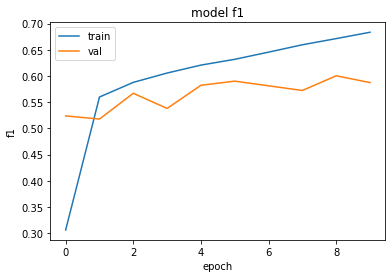

In [25]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Домашка

Сверточные сети относительно хорошо масшабируются на длинные последовательности. Поэтому их часто применяют к отдельным символам, а не токенам. В домашке вам нужно будет обучить большую сверточную модель на символах (отличаться по сути будет только токенизация).

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру.

Конкретнее задание такое:
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга. Должен быть хотя бы один слой каждого типа.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Сделайте размер эмбединга сильно меньше. Попробуйте паддинг поменьше. Символьная модель может обучаться намного дольше. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


Бонусный балл можно получить за изучение влияния предобработки (нужно ли приводить к нижнему регистру, нужно ли выкидывать не алфавитные символы, помогает ли замена цифр на определенный токен).